<a href="https://colab.research.google.com/github/Khojasteh-hb/subtype_prediction/blob/main/01_subtype_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/coad_tiles')
directory = os.getcwd()
print("The Current working directory is :", directory)

The Current working directory is : /content/drive/MyDrive/coad_tiles


In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow=='2.7.0'

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [ ]:
# reading csv file
df_colorectal = pd.read_csv("/content/drive/MyDrive/df_colorectal.csv")

df_colorectal.rename({"Unnamed: 0":"redundant"}, axis="columns", inplace=True)
df_colorectal.drop(["redundant"], axis=1, inplace=True)

df_colorectal.head(5)

,image_path,CMS_Subtype
0,TCGA-A6-2671-01Z-00-DX1.13d1a0d9-78cd-4cfc-b67...,CMS4
1,TCGA-A6-2671-01Z-00-DX1.13d1a0d9-78cd-4cfc-b67...,CMS4
2,TCGA-A6-2671-01Z-00-DX1.13d1a0d9-78cd-4cfc-b67...,CMS4
3,TCGA-A6-2671-01Z-00-DX1.13d1a0d9-78cd-4cfc-b67...,CMS4
4,TCGA-A6-2671-01Z-00-DX1.13d1a0d9-78cd-4cfc-b67...,CMS4


In [ ]:
df_colorectal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126747 entries, 0 to 126746
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   image_path   126747 non-null  object
 1   CMS_Subtype  126747 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [ ]:
df_colorectal['CMS_Subtype'].value_counts()

CMS2    48812
CMS4    34964
CMS1    21941
CMS3    21030
Name: CMS_Subtype, dtype: int64

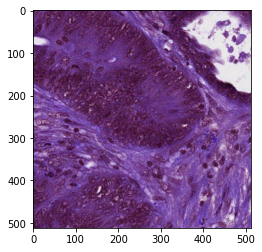

In [ ]:
#Randomly displaying an MRI image from the dataset.
image = cv2.imread(df_colorectal.image_path[1301])
plt.imshow(image)

In [ ]:
#Analyze the pixel values of the mask image.
cv2.imread(df_colorectal.image_path[1301]).max()

255

In [ ]:
cv2.imread(df_colorectal.image_path[1301]).min()

0

In [ ]:
# split the data into train and test data
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_colorectal, test_size = 0.15)

In [ ]:
# create an image generator
from keras_preprocessing.image import ImageDataGenerator

#Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='CMS_Subtype',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='CMS_Subtype',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='CMS_Subtype',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 91574 validated image filenames belonging to 4 classes.
Found 16160 validated image filenames belonging to 4 classes.
Found 19013 validated image filenames belonging to 4 classes.


In [ ]:
# Get the ResNet50 base model (Transfer Learning)
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))
basemodel.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
# freeze the model weights
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# compile the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)